C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is av

Training Set Metrics (SARIMAX):
{'RMSE': 1836.5477198952524, 'MSE': 3372907.5274524507, 'MAE': 1617.0090087699523, 'MAPE': 324.9647435163231}

Validation Set Metrics (SARIMAX):
{'RMSE': 1899.6175434579054, 'MSE': 3608546.8114130474, 'MAE': 1669.8192885148073, 'MAPE': 122.88644515849039}


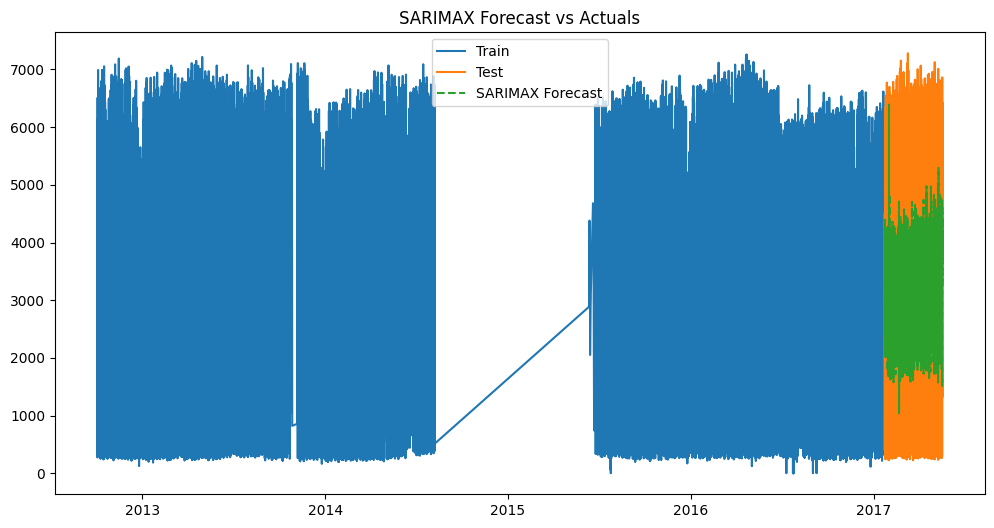

['sarimax_model.joblib']

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV  # Changed to GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
import matplotlib.pyplot as plt
import joblib

# Custom wrapper for SARIMAX
class SARIMAXWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0)):
        self.order = order
        self.seasonal_order = seasonal_order
    
    def fit(self, X, y):
        self.model = SARIMAX(y, exog=X, order=self.order, seasonal_order=self.seasonal_order)
        self.results = self.model.fit(disp=False)
        return self

    def predict(self, X):
        return self.results.get_forecast(steps=len(X), exog=X).predicted_mean

# Define custom scorer for MAPE
def mape_scorer(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Load the dataset
df_raw = pd.read_csv('../Train.csv')

# Convert the 'date_time' column to datetime and sort the dataset
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'])
df_raw.sort_values('date_time', inplace=True)
df_raw.set_index('date_time', inplace=True)

# Extract hour from the 'date_time' column
df_raw['hour'] = df_raw.index.hour

# One-hot encode categorical features
df = pd.get_dummies(df_raw, columns=['is_holiday', 'weather_type', 'weather_description'], drop_first=True)

# Remove rows with NaN values resulting from lagged features
df.dropna(inplace=True)

# Split the dataset into features and the target
X = df.drop('traffic_volume', axis=1)
y = df['traffic_volume']

# Split the data into train and test sets
total_samples = df.shape[0]
split_index = int(total_samples * 0.9)

X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

# Adjusted parameter grid
param_grid = {
    'order': [(p, d, q) for p in range(0, 3) for d in range(0, 2) for q in range(0, 3)],
    'seasonal_order': [(p, d, q, 12) for p in range(0, 2) for d in range(0, 2) for q in range(0, 2)]
}

# Create the SARIMAX wrapper instance
sarimax = SARIMAXWrapper()

# Initialize GridSearchCV
grid_search = GridSearchCV(sarimax, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV to find the best model
grid_search.fit(X_train, y_train)

# Use the best estimator to make predictions
best_sarimax = grid_search.best_estimator_
predicted_traffic_volume_sarimax = best_sarimax.predict(X_test)

# Evaluate metrics
def evaluate_metrics(y_true, y_pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MSE': mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': mape_scorer(y_true, y_pred)
    }

train_metrics_sarimax = evaluate_metrics(y_train, best_sarimax.predict(X_train))
val_metrics_sarimax = evaluate_metrics(y_test, predicted_traffic_volume_sarimax)

# Print and compare metrics for SARIMAX
print("Training Set Metrics (SARIMAX):")
print(train_metrics_sarimax)

print("\nValidation Set Metrics (SARIMAX):")
print(val_metrics_sarimax)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, predicted_traffic_volume_sarimax, label='SARIMAX Forecast', linestyle='--')
plt.legend()
plt.title('SARIMAX Forecast vs Actuals')
plt.show()

# Save the trained SARIMAX model
joblib.dump(best_sarimax, 'sarimax_model.joblib')

C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


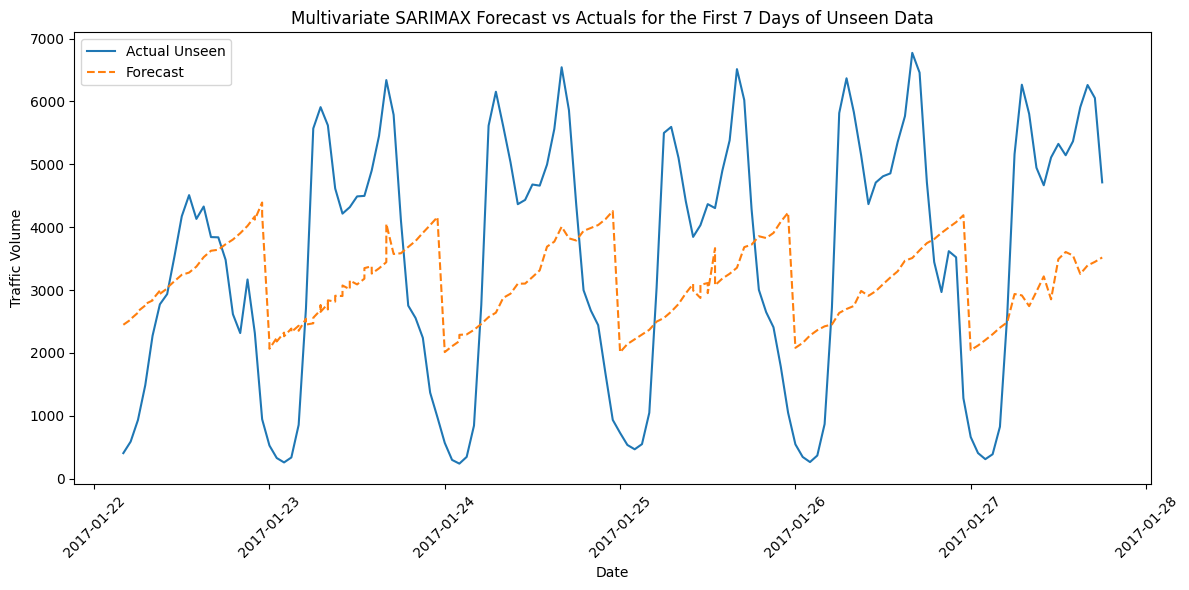

In [3]:
# Make predictions on the first 7 days of unseen data
forecast_unseen = best_sarimax.results.get_forecast(steps=7 * 24, exog=X_test.iloc[:7 * 24])
predicted_traffic_volume_unseen = forecast_unseen.predicted_mean

# Evaluate metrics on the unseen data for SARIMAX
unseen_metrics_sarimax = evaluate_metrics(y_test.iloc[:7 * 24], predicted_traffic_volume_unseen)

# Visualization for the first 7 days of unseen data
plt.figure(figsize=(12, 6))
plt.plot(y_test.index[:7 * 24], y_test.iloc[:7 * 24], label='Actual Unseen')
plt.plot(y_test.index[:7 * 24], predicted_traffic_volume_unseen, label='Forecast', linestyle='--')
plt.legend()
plt.title('Multivariate SARIMAX Forecast vs Actuals for the First 7 Days of Unseen Data')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()